In [ ]:
!pip install nevergrad

# Importación de los datos

En primer lugar se importarán los ficheros relativos al conjunto de datos de **entrenamiento** y **test**. Para ello se han descargado de la competición de Kaggle y se han subido a un repositorio público en **GitHub** desde donde se importarán. Haciendo esto evitamos tener que adjuntar al notebook los ficheros cada vez que vayamos a trabajar, ya que estos se **importarán automáticamente** desde el repositorio.

In [ ]:
import pandas as pd
import requests
import io

train_url = "https://raw.githubusercontent.com/cturienzo/ClasificationDataset/main/train.csv"
test_url = "https://raw.githubusercontent.com/cturienzo/ClasificationDataset/main/test.csv"

train_request = requests.get(train_url).content
test_request = requests.get(test_url).content

train = pd.read_csv(io.StringIO(train_request.decode('utf-8')))
test = pd.read_csv(io.StringIO(test_request.decode('utf-8')))

Una vez importados los datos, vamos a separarlos en diferentes variables para facilitar la comprensión:

**X_train** se corresponderá con la matriz que contiene los valores de las características del conjunto de datos de entrenamiento.

**y_train** se corresponderá con la matriz unidimensional de valores de la variable objetivo.

**X_test** se corresponderá con la matriz que contiene los valores de las características del conjunto de datos de test eliminando el campo índice.

In [ ]:
X_train = train.iloc[:,:-2]
y_train = train.iloc[:,-1]
X_test = test.iloc[:, 1:]

# Análisis de los datos

En primer lugar vamos a echar un vistazo a la descripción de los datos de entrenamiento.

In [ ]:
X_train.describe()

,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,...,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
count,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.00000,73446.000000,73446.0,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.0,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.0,73446.000000,73446.000000,73446.000000,73446.000000,...,73446.000000,73446.000000,73446.0,73446.000000,73446.0,73446.000000,73446.000000,73446.0,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000
mean,97.879891,6.700324,6.776720,411.646883,402.341339,314.032337,298.506849,9726.591646,11204.361708,2.044822,2.771805,1.604757,4.269150,4.262696,0.274093,1.244670,0.135855,0.007570,0.57095,0.321079,0.0,0.000123,0.150723,0.106895,0.004044,0.001675,0.110503,0.004847,0.0,0.000803,0.010756,0.109169,0.006685,3.305177,0.000014,0.0,0.063325,0.002723,1.074272,0.053522,...,0.000177,0.000136,0.0,0.000054,0.0,0.000136,0.000749,0.0,0.236473,0.822591,0.060085,0.020968,0.046647,0.035822,0.007557,0.000313,0.442025,0.381028,0.061433,0.009585,3.177328,0.121600,0.234989,0.292215,0.174536,0.005147,0.008033,0.028565,0.895529,0.437001,1.847153,1.860469,1.537116,1.622580,0.997481,0.020015,0.047600,1.352817,0.027966,0.025257
std,54.483397,4.798172,4.825463,132.899609,140.319983,170.948921,174.248528,11160.528865,12108.490387,1.839160,2.009263,1.601898,1.210847,1.230767,0.583865,1.363836,0.464000,0.091119,0.67266,0.476821,0.0,0.011069,0.443491,0.383039,0.063463,0.040889,0.390561,0.071386,0.0,0.037802,0.109927,0.402671,0.085406,1.626261,0.003690,0.0,0.260669,0.052632,1.219812,0.247765,...,0.013303,0.011668,0.0,0.007380,0.0,0.011668,0.027355,0.0,0.551851,1.138394,0.267561,0.148137,0.231091,0.208759,0.087694,0.017694,0.837222,0.811299,0.286792,0.100868,1.589641,0.438699,0.532801,0.579831,0.426305,0.077581,0.094887,0.192163,1.277589,0.808155,1.771293,1.795563,1.736907,1.829159,1.453753,0.145300,0.225829,1.665517,0.170560,0.162615
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000

En segundo lugar vamos a comprobar si el dataset está **desbalanceado**. Para ello vamos a pintar un **histograma** para conocer la frecuencia con la que ganan los Terroristas (T) y la frecuencia con la que ganan los AntiTerroristas (CT)

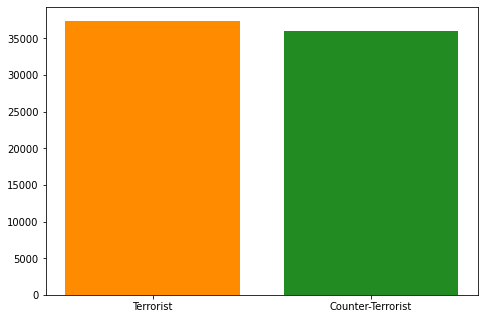

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
clases = ['Terrorist', 'Counter-Terrorist']
num = y_train.value_counts() # Contamos el número de CT y de T del dataset de entrenamiento
colors = ['darkorange', 'forestgreen']
ax.bar(clases,num, color=colors)
plt.show()

Observando el gráfico anterior vemos que el dataset **no está desbalanceado**,pues el número de veces que ganan los T y los CT son muy similares.

Más adelante vamos a pintar un gráfico por cada feature para analizarla y aplicar un preprocesamiento concreto.

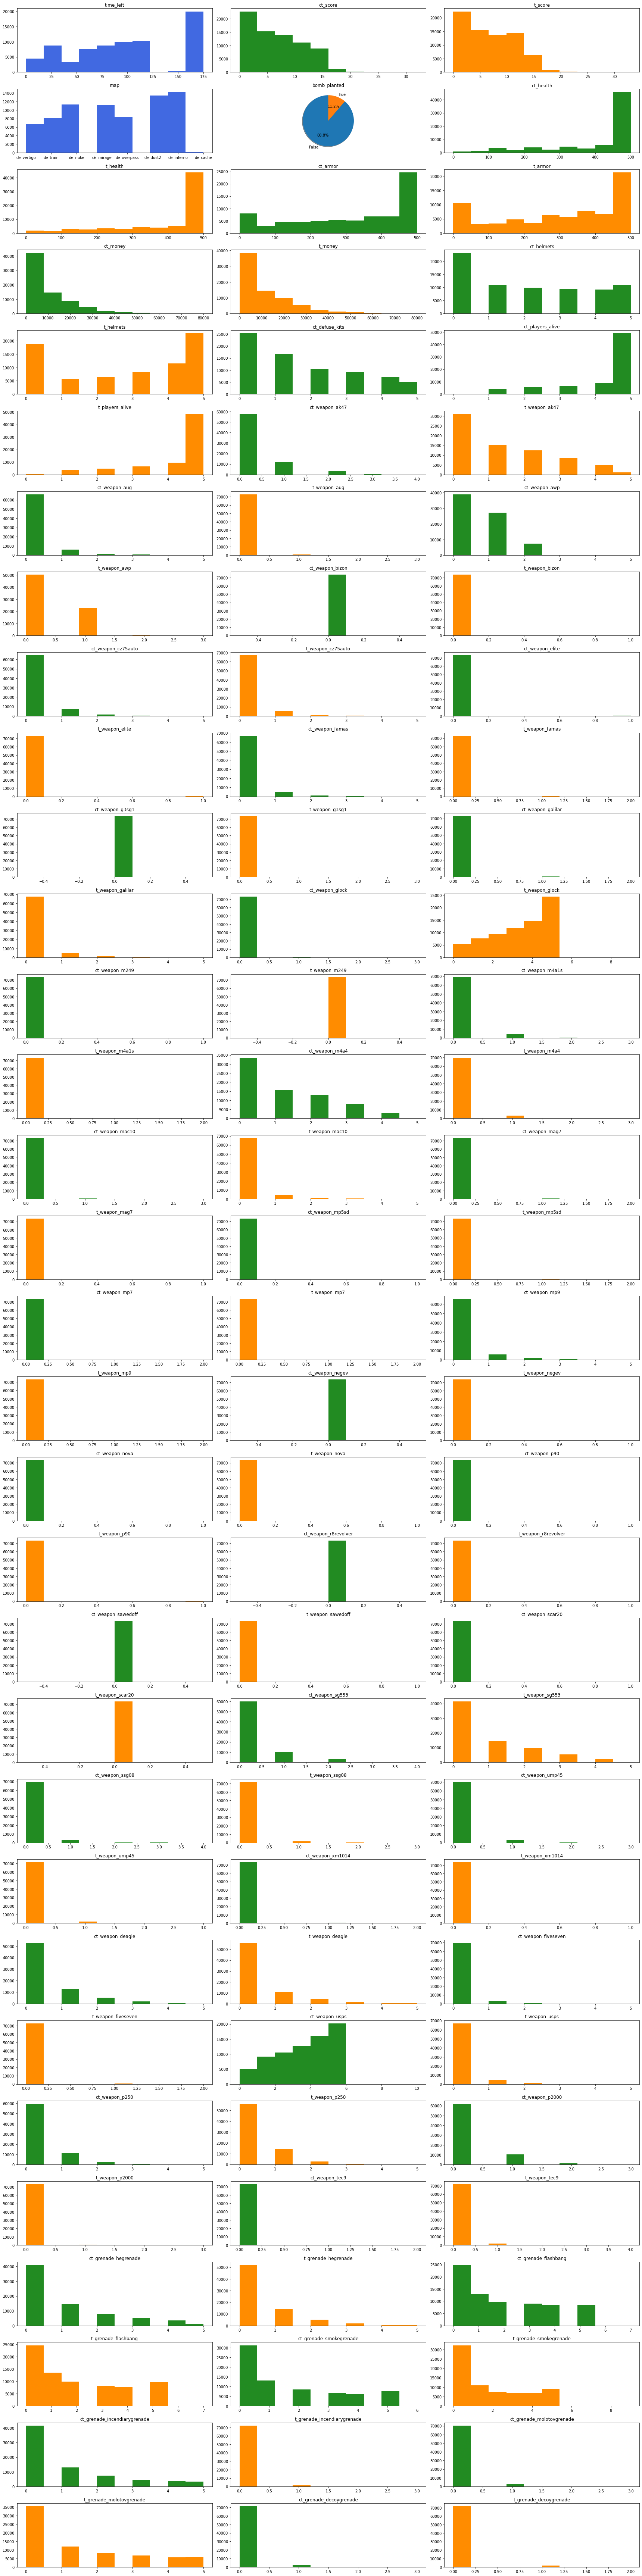

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=32, ncols=3, figsize=(24,96))


for feature, ax in zip(X_train.columns, axes.flatten()):
  if(feature != 'bomb_planted'):
    if(feature[0:2]=='ct'):
      ax.hist(X_train[feature], rwidth=1, align='mid', color='forestgreen')
    elif(feature[0:2]=='t_'):
      ax.hist(X_train[feature], rwidth=1, align='mid', color='darkorange')
    else: 
      ax.hist(X_train[feature], rwidth=1, align='mid', color='royalblue')

  else:
    ax.pie(X_train[feature].value_counts(), labels=['False','True'], autopct='%1.1f%%',
        shadow=True, startangle=90)
  ax.title.set_text(feature)

plt.tight_layout()  
plt.show()

Después vamos a conocer que **equipos ganan más por cada mapa**

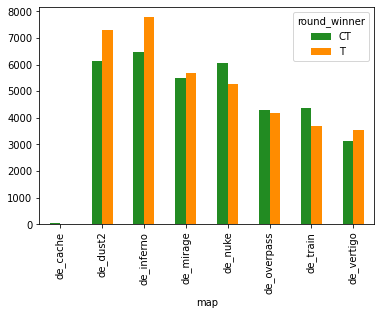

In [ ]:
df = train.groupby(['map','round_winner']).size().reset_index(name='counts')
df.pivot(index="map", columns="round_winner", values="counts").plot(kind="bar", color=["forestgreen", "darkorange"])
plt.show()

Después vamos a conocer que **equipos ganan más según si se ha plantado la bomba o no**

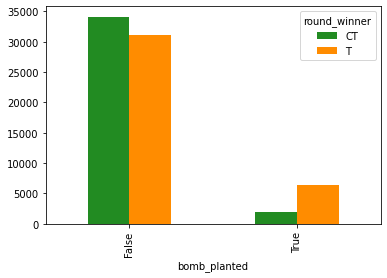

In [ ]:
df = train.groupby(['bomb_planted','round_winner']).size().reset_index(name='counts')
df.pivot(index="bomb_planted", columns="round_winner", values="counts").plot(kind="bar", color=["forestgreen", "darkorange"])
plt.show()

# Pre-procesamiento

Una vez analizados los datos vamos a aplicar el siguiente **preprocesamiento**.

In [ ]:
import numpy as np
def zero_mean_features(): 
  features = []
  for feature in X_train.select_dtypes(include=np.number).columns:
    if(X_train[feature].mean() == 0):
      features.append(feature)
  return features

In [ ]:
X_train = X_train.drop(columns=zero_mean_features())

In [ ]:
import sklearn.compose
column_transformer = sklearn.compose.ColumnTransformer(transformers=[
    ("map",sklearn.preprocessing.OrdinalEncoder(), [3]), 
    ("bomb_planted", sklearn.preprocessing.OneHotEncoder(), [4]), 
],
    remainder=sklearn.preprocessing.RobustScaler())

X_train_transform = column_transformer.fit_transform(X_train)
X_test_transform = column_transformer.transform(X_test)


Preprocesamineto especial para el **miltinomial Naive Bayes** puesto que no admite valores negativos.

In [ ]:
import sklearn.compose
column_transformer = sklearn.compose.ColumnTransformer(transformers=[
    ("map",sklearn.preprocessing.OrdinalEncoder(), [3]), 
    ("bomb_planted", sklearn.preprocessing.OneHotEncoder(), [4]), 
],
    remainder="passthrough")

X_train_transform = column_transformer.fit_transform(X_train)
X_test_transform = column_transformer.transform(X_test)

Transformamos los datos del conjunto de entrenamiento para que puedan servir como entrada del modelo de ML.

# Modelos

Antes de entrenar cada modelo vamos a **dividir** el conjunto de datos de entrenamiento en dos:



*   Por una parte, el **70%** de los datos representarán el conjunto de entrenamiento en sí.
*   Por otra parte, el otro **30%** se utilizará como conjunto de validación para validar los modelos.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_transform, y_train, test_size=0.3, random_state=42)

## Random Forest

### Optimización hiperparámetros

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


def random_F(n_estimators, criterion, max_depth, min_samples_split, x_train=X_train, y_train=y_train, x_test=X_val, y_test=y_val):
    
    #Instanciamos el modelo
    model = RandomForestClassifier(
        n_estimators= n_estimators,
        criterion= criterion,
        max_depth= max_depth,
        min_samples_split= min_samples_split
    )

    #Entrenamos el modelo
    model.fit(x_train, y_train)

    #Predecimos los resultados
    y_pred = model.predict(x_test)

    f1 = f1_score(y_test, y_pred, average='weighted')
    print("F1: ", f1)
    #Devolvemos el valor de F1 que será minimizado
    return -f1

    
    
   

In [ ]:
import nevergrad as ng

n_estimators = ng.p.TransitionChoice(range(100, 1000, 100))
criterion = ng.p.Choice(['gini', 'entropy'])
max_depth = ng.p.TransitionChoice([20, 30, 40, 50])
min_samples_split = ng.p.TransitionChoice([2,3,4])

params = ng.p.Instrumentation(n_estimators, criterion, max_depth, min_samples_split)
optimizer = ng.optimizers.TwoPointsDE(parametrization=params, budget=100)
best = optimizer.minimize(random_F, batch_mode=False)

In [ ]:
best.value

((800, 'entropy', 50, 2), {})

Enrenamos el modelo con el conjunto de entrenamiento partido con **train_test_split** anteriormente.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
randomForest = RandomForestClassifier(n_estimators=800, criterion='entropy', max_depth=50,min_samples_split=2, random_state=43)
randomForest.fit(X_train, y_train)
y_pred_val = randomForest.predict(X_val)
y_pred_val

array(['CT', 'CT', 'T', ..., 'T', 'CT', 'CT'], dtype=object)

### Validación Random Forest

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred_val, y_val))

              precision    recall  f1-score   support

          CT       0.86      0.83      0.85     11120
           T       0.83      0.86      0.85     10914

    accuracy                           0.85     22034
   macro avg       0.85      0.85      0.85     22034
weighted avg       0.85      0.85      0.85     22034



### Generación Predicciones RandomForest

In [ ]:
y_pred = randomForest.predict(X_test_transform)
predicciones = pd.DataFrame({'id':test["id"], 'round_winner': y_pred })
predicciones.to_csv("prediccionesRandomForest.csv", index=False)

## XGBClassifier

### Optimización hiperparámetros

In [ ]:

from xgboost import XGBClassifier

xgbc = XGBClassifier(learning_rate= 0.05,
                     n_estimators=900,
                     subsample=1,
                     max_depth=80,
                     n_jobs = -1,
                     tree_method = "hist", 
                     single_precision_histogram=True                           
                    ).fit(X_train, y_train)
y_pred_val = xgbc.predict(X_val)
y_pred_val

array(['CT', 'CT', 'T', ..., 'T', 'CT', 'CT'], dtype=object)

### Validación XGB

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred_val, y_val))

              precision    recall  f1-score   support

          CT       0.85      0.85      0.85     10870
           T       0.85      0.86      0.86     11164

    accuracy                           0.85     22034
   macro avg       0.85      0.85      0.85     22034
weighted avg       0.85      0.85      0.85     22034



### Generación Predicciones XGBClassifier

In [ ]:
y_pred = xgbc.predict(X_test_transform)
predicciones = pd.DataFrame({'id':test["id"], 'round_winner': y_pred })
predicciones.to_csv("prediccionesXGB.csv", index=False)

## Naive Bayes Classifier

### Optimización de hiperparámetros

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

import numpy as np

parameters={
    'alpha': np.arange(0.1,0.9,0.1),
    'fit_prior': [True, False]
}
multi_NB = MultinomialNB()
gs = GridSearchCV(multi_NB, parameters, verbose=1, cv=3)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=MultinomialNB(),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                         'fit_prior': [True, False]},
             verbose=1)

In [ ]:
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_prior,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.156606,0.010099,0.073676,0.003634,0.1,True,"{'alpha': 0.1, 'fit_prior': True}",0.612557,0.613935,0.611542,0.612678,0.00098,1
1,0.157450,0.002101,0.075258,0.003688,0.1,False,"{'alpha': 0.1, 'fit_prior': False}",0.612557,0.613935,0.611542,0.612678,0.00098,1
2,0.154430,0.001663,0.072327,0.002359,0.2,True,"{'alpha': 0.2, 'fit_prior': True}",0.612557,0.613935,0.611542,0.612678,0.00098,1
3,0.158950,0.003855,0.071460,0.000691,0.2,False,"{'alpha': 0.2, 'fit_prior': False}",0.612557,0.613935,0.611542,0.612678,0.00098,1
4,0.155553,0.001480,0.071395,0.001500,0.3,True,"{'alpha': 0.30000000000000004, 'fit_prior': True}",0.612557,0.613935,0.611542,0.612678,0.00098,1
5,0.155285,0.002989,0.071398,0.000794,0.3,False,"{'alpha': 0.30000000000000004, 'fit_prior': Fa...",0.612557,0.613935,0.611542,0.612678,0.00098,1
6,0.157183,0.003638,0.070760,0.000773,0.4,True,"{'alpha': 0.4, 'fit_prior': True}",0.612557,0.613935,0.611542,0.612678,0.00098,1
7,0.154004,0.000455,0.071203,0.000997,0.4,False,"{'alpha': 0.4, 'fit_prior': False}",0.612557,0.613935,0.611542,0.612678,0.00098,1
8,0.151975,0.001360,0.074773,0.001844,0.5,True,"{'alpha': 0.5, 'fit_prior': True}",0.612557,0.613935,0.611542,0.612678,0.00098,1
9,0.155337,0.002991,0.071072,0.001101,0.5,False,"{'alpha': 0.5, 'fit_prior': False}",0.612557,0.613935,0.611542,0.612678,0.00098,1


In [ ]:
from sklearn.naive_bayes import MultinomialNB

multi_NB = MultinomialNB(
                    alpha= 0.1,
                    fit_prior= True
                    ).fit(X_train, y_train)
y_pred_val = multi_NB.predict(X_val)
y_pred_val

array(['CT', 'CT', 'CT', ..., 'T', 'CT', 'CT'], dtype='<U2')

### Validación Naive Bayes

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred_val, y_val))

              precision    recall  f1-score   support

          CT       0.62      0.60      0.61     11198
           T       0.60      0.62      0.61     10836

    accuracy                           0.61     22034
   macro avg       0.61      0.61      0.61     22034
weighted avg       0.61      0.61      0.61     22034



### Generación Predicciones Naive Bayes

In [ ]:
y_pred = multi_NB.predict(X_test_transform)
predicciones = pd.DataFrame({'id':test["id"], 'round_winner': y_pred })
predicciones.to_csv("prediccionesMultinomialNB.csv", index=False)

## Nearest Centroid

### Optimización de hiperparámetros

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestCentroid

import numpy as np

parameters={
    'metric': ["manhattan"],
    'shrink_threshold': np.arange(1,10, 0.1)
}
nearest_Centroid = NearestCentroid()
gs = GridSearchCV(nearest_Centroid, parameters, verbose=1, cv=3)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


GridSearchCV(cv=3, estimator=NearestCentroid(),
             param_grid={'metric': ['manhattan'],
                         'shrink_threshold': array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
       4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1,
       6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4,
       7.5, 7.6, 7.7, 7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7,
       8.8, 8.9, 9. , 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             verbose=1)

In [ ]:
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_shrink_threshold,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
17,0.122202,0.001171,0.043466,0.000204,manhattan,2.7,"{'metric': 'manhattan', 'shrink_threshold': 2....",0.655561,0.525938,0.598996,0.593498,0.053061,1
14,0.121734,0.001195,0.045758,0.002612,manhattan,2.4,"{'metric': 'manhattan', 'shrink_threshold': 2....",0.653985,0.525821,0.599230,0.593012,0.052507,2
15,0.123550,0.002760,0.044458,0.001554,manhattan,2.5,"{'metric': 'manhattan', 'shrink_threshold': 2....",0.654044,0.525763,0.599055,0.592954,0.052548,3
16,0.122792,0.003277,0.043853,0.000247,manhattan,2.6,"{'metric': 'manhattan', 'shrink_threshold': 2....",0.654160,0.525763,0.598938,0.592954,0.052589,4
18,0.120482,0.000462,0.043905,0.000167,manhattan,2.8,"{'metric': 'manhattan', 'shrink_threshold': 2....",0.652235,0.525705,0.599113,0.592351,0.051877,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0.122234,0.001631,0.044210,0.000922,manhattan,9.4,"{'metric': 'manhattan', 'shrink_threshold': 9....",0.606489,0.525646,0.598938,0.577024,0.036460,86
87,0.121323,0.000676,0.045845,0.002708,manhattan,9.7,"{'metric': 'manhattan', 'shrink_threshold': 9....",0.606372,0.525705,0.598938,0.577005,0.036401,87
88,0.124519,0.001391,0.044605,0.001226,manhattan,9.8,"{'metric': 'manhattan', 'shrink_threshold': 9....",0.606197,0.525705,0.598938,0.576946,0.036354,88
86,0.127853,0.005204,0.046665,0.002644,manhattan,9.6,"{'metric': 'manhattan', 'shrink_threshold': 9....",0.606430,0.525588,0.598821,0.576946,0.036449,89


In [ ]:
from sklearn.neighbors import NearestCentroid

nearest_Centroid = NearestCentroid(metric="manhattan", shrink_threshold=2.7).fit(X_train, y_train)
y_pred_val = nearest_Centroid.predict(X_val)
y_pred_val

array(['CT', 'CT', 'CT', ..., 'CT', 'T', 'CT'], dtype=object)

### Validación Nearest Centroid

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred_val, y_val))

              precision    recall  f1-score   support

          CT       0.63      0.59      0.61     11623
           T       0.58      0.62      0.60     10411

    accuracy                           0.60     22034
   macro avg       0.61      0.61      0.60     22034
weighted avg       0.61      0.60      0.60     22034



### Generación Predicciones Nearest Centroid

In [ ]:
y_pred = nearest_Centroid.predict(X_test_transform)
predicciones = pd.DataFrame({'id':test["id"], 'round_winner': y_pred })
predicciones.to_csv("prediccionesNearestCentroid.csv", index=False)

## GradientBoostingClassifier

### Optimización de hiperparámetros

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score


def gradient(n_estimators, learning_rate, max_depth, subsample, max_features, x_train=X_train, y_train=y_train, x_test=X_val, y_test=y_val):
    
    #Instanciamos el modelo
    model = GradientBoostingClassifier(
        n_estimators= n_estimators,
        learning_rate= learning_rate,
        max_depth= max_depth,
        subsample= subsample,
        max_features=max_features
    )

    #Entrenamos el modelo
    model.fit(x_train, y_train)

    #Predecimos los resultados
    y_pred = model.predict(x_test)

    f1 = f1_score(y_test, y_pred, average='weighted')
    print("F1: ", f1, " Parámetros: {n_estimators:", n_estimators, ", learning_rate:", learning_rate, ", max_depth:", max_depth, ", subsample:", subsample, ", max_features:", max_features, "}" )
    #Devolvemos el valor de F1 que será minimizado
    return -f1

In [ ]:
import nevergrad as ng

n_estimators = ng.p.TransitionChoice(range(100, 1000, 100))
learning_rate = ng.p.Scalar(lower=0.001, upper=0.005)
max_depth = ng.p.TransitionChoice(range(100, 1000, 100))
subsample = ng.p.Scalar(lower=0.1, upper=0.9)
max_features = ng.p.Choice(['sqrt','log2'])

params = ng.p.Instrumentation(n_estimators, learning_rate, max_depth, subsample, max_features)
optimizer = ng.optimizers.TwoPointsDE(parametrization=params, budget=100)
best = optimizer.minimize(gradient, batch_mode=False)

In [ ]:
best.value

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
 
gradient_boosting = GradientBoostingClassifier(
                    learning_rate= 0.004,
                    n_estimators= 800,
                    max_depth= 700,
                    subsample= 0.85,
                    max_features= "sqrt" 
                    ).fit(X_train, y_train)
y_pred_val = gradient_boosting.predict(X_val)
y_pred_val

array(['CT', 'CT', 'T', ..., 'T', 'CT', 'CT'], dtype=object)

### Validación Gradient Boosting

In [ ]:

from sklearn.metrics import classification_report
print(classification_report(y_pred_val, y_val))

              precision    recall  f1-score   support

          CT       0.86      0.84      0.85     11057
           T       0.84      0.86      0.85     10977

    accuracy                           0.85     22034
   macro avg       0.85      0.85      0.85     22034
weighted avg       0.85      0.85      0.85     22034





### Generación Predicciones Gradient Boosting


In [ ]:
y_pred = gradient_boosting.predict(X_test_transform)
predicciones = pd.DataFrame({'id':test["id"], 'round_winner': y_pred })
predicciones.to_csv("prediccionesGradientBoosting.csv", index=False)

## K-Nearest Neighbors

### Optimización de hiperparámetros

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=15, weights="distance", n_jobs=-1).fit(X_train, y_train)
y_pred_val = knn.predict(X_val)
y_pred_val

array(['T', 'CT', 'T', ..., 'T', 'CT', 'CT'], dtype=object)

### Validación K-Nearest Neighbors

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred_val, y_val))

              precision    recall  f1-score   support

          CT       0.82      0.79      0.81     11244
           T       0.79      0.82      0.81     10790

    accuracy                           0.81     22034
   macro avg       0.81      0.81      0.81     22034
weighted avg       0.81      0.81      0.81     22034



### Generación predicciones K-Nearest Neighbors

In [ ]:
y_pred = knn.predict(X_test_transform)
predicciones = pd.DataFrame({'id':test["id"], 'round_winner': y_pred })
predicciones.to_csv("prediccionesKNN.csv", index=False)

## Red Neuronal

### Optimización de Hiperparámetros

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score


def mlp_op(activation, solver, alpha, learning_rate, learning_rate_init, max_iter, x_train=X_train, y_train=y_train, x_test=X_val, y_test=y_val):
    
    #Instanciamos el modelo
    model = MLPClassifier(
        activation=activation,
        solver=solver,
        alpha=alpha,
        learning_rate=learning_rate,
        learning_rate_init=learning_rate_init,
        max_iter=max_iter


    )
    #Entrenamos el modelo
    model.fit(x_train, y_train)

    #Predecimos los resultados
    y_pred = model.predict(x_test)

    f1 = f1_score(y_test, y_pred, average='weighted')
    print("F1: ", f1)
    #Devolvemos el valor de F1 que será minimizado
    return -f1

In [ ]:
import nevergrad as ng

activation = ng.p.Choice(['identity','logistic','tanh','relu'])
solver = ng.p.Choice(["lbfgs","sgd","adam"])
alpha = ng.p.Scalar(lower=0.0001, upper=0.005)
learning_rate = ng.p.Choice(["constant","adaptive","invscaling"])
learning_rate_init = ng.p.Scalar(lower=0.0001, upper=0.005)
max_iter = ng.p.TransitionChoice(range(100,1000,100))


params = ng.p.Instrumentation(activation, solver, alpha, learning_rate, learning_rate_init, max_iter)
optimizer = ng.optimizers.TwoPointsDE(parametrization=params, budget=100)
best = optimizer.minimize(mlp_op, batch_mode=False)

In [ ]:
best.value

(('relu',
  'sgd',
  0.0036737083704807844,
  'adaptive',
  0.0024936023482253545,
  300),
 {})

In [ ]:

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='adam', alpha=0.01, activation='relu',hidden_layer_sizes=(5, 2), random_state=1, max_iter=1000)
mlp.fit(X_train, y_train)
y_pred_val = mlp.predict(X_val)
y_pred_val

array(['T', 'T', 'T', ..., 'T', 'CT', 'CT'], dtype='<U2')

### Validación MLP

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred_val, y_val))

              precision    recall  f1-score   support

          CT       0.71      0.75      0.73     10264
           T       0.77      0.74      0.75     11770

    accuracy                           0.74     22034
   macro avg       0.74      0.74      0.74     22034
weighted avg       0.74      0.74      0.74     22034



### Generación predicciones MLP

In [ ]:
y_pred = mlp.predict(X_test_transform)
predicciones = pd.DataFrame({'id':test["id"], 'round_winner': y_pred })
predicciones.to_csv("prediccionesMLP.csv", index=False)

## Ada Boost Classifier

### Optimización de Hiperparámetros

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier( max_depth=50,criterion="gini"),n_estimators=100) 


ada.fit(X_train, y_train)
y_pred_val = ada.predict(X_val)
y_pred_val

array(['CT', 'CT', 'T', ..., 'T', 'CT', 'CT'], dtype=object)

### Validación AdaBoost Classifier

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred_val, y_val))

              precision    recall  f1-score   support

          CT       0.84      0.83      0.84     10910
           T       0.84      0.84      0.84     11124

    accuracy                           0.84     22034
   macro avg       0.84      0.84      0.84     22034
weighted avg       0.84      0.84      0.84     22034



### Generación predicciones AdaBoost Classifier

In [ ]:
y_pred = ada.predict(X_test_transform)
predicciones = pd.DataFrame({'id':test["id"], 'round_winner': y_pred })
predicciones.to_csv("prediccionesADA.csv", index=False)

## Elección del Modelo

Para validar los modelos vamos vamos a pintar sus **matrices de confusión** y comparararemos para conocer cual proporciona mejores resultados.
Además de cada modelo mostraremos las distintas **métricas** de clasificación.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMa

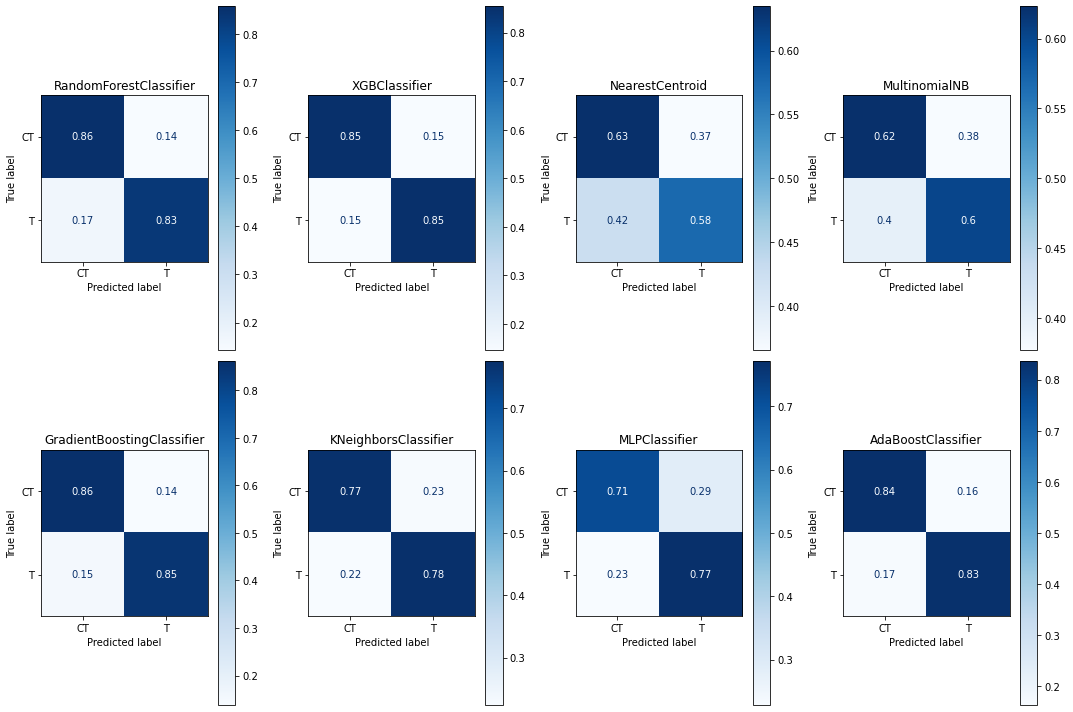

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

models = [randomForest, xgbc, nearest_Centroid, multi_NB, gradient_boosting, knn, mlp, ada] 


for cls, ax in zip(models, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_val, 
                          y_val,
                          normalize="true",
                          ax=ax, 
                          cmap='Blues')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

# Vídeo Explicativo


El enlace al vídeo es el siguiente: https://www.dropbox.com/s/w6wgffw8tpvf0bt/Video%20Pr%C3%A1ctica%20Clasificaci%C3%B3n%20GutierrezRojas-TurienzoForcada.mp4?dl=0

<hr>

Creado por **Pablo Gutiérrez Rojas** (p.grojas@alumnos.upm.es) y **César Turienzo Forcada** (c.turienzo@alumnos.upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">